In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# jax
import jax.numpy as jnp
import time

import sys
import os

path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)

from collocation_obj import Collocation
from non_parametric_collocation import collocate_data

import statsmodels.api as sm
from data_generation import generate_ode_data

path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)

In [2]:
import importlib
import nn_pyomo_admm

def reload_module(module_name, class_name):
    module = importlib.import_module(module_name)
    importlib.reload(module)
    return getattr(module, class_name)

In [3]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # 'chebyshev', 'gauss_legendre', 'gauss_radau', 'gauss_lobatto'
initial_state = jnp.array([0.0, 1.0])

collocation = Collocation(N, start_time, end_time, 'chebyshev')
t_vdp_cheb_1 = collocation.compute_nodes()

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb_1, y_vdp_cheb_1, y_noisy_vdp_cheb_1, true_derivatives_vdp_cheb_1 = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state, t = t_vdp_cheb_1)

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
D_vdp_cheb_1 = np.array(collocation.compute_derivative_matrix())

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
est_der_vdp_cheb_1, est_sol_vdp_cheb_1 = collocate_data(y_noisy_vdp_cheb_1, t_vdp_cheb_1, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [4]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
# redefine the start time and the initial state
start_time, end_time = 15, 30 
initial_state = y_vdp_cheb_1[-1]

collocation = Collocation(N, start_time, end_time, 'chebyshev')
t_vdp_cheb_2 = collocation.compute_nodes()

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb_2, y_vdp_cheb_2, y_noisy_vdp_cheb_2, true_derivatives_vdp_cheb_2 = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state, t = t_vdp_cheb_2)

# numpy array is required for pyomo
y_noisy_vdp_cheb_2 = np.array(jnp.squeeze(y_noisy_vdp_cheb_2))
t_vdp_cheb_2 = np.array(jnp.squeeze(t_vdp_cheb_2))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
D_vdp_cheb_2 = np.array(collocation.compute_derivative_matrix())

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
est_der_vdp_cheb_2, est_sol_vdp_cheb_2 = collocate_data(y_noisy_vdp_cheb_2, t_vdp_cheb_2, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


### Merge Data

In [5]:
ys = np.concatenate([np.atleast_2d(y_noisy_vdp_cheb_1[:, 0]), np.atleast_2d(y_noisy_vdp_cheb_2[:, 0])], axis = 1).T
ts = np.concatenate([t_vdp_cheb_1, t_vdp_cheb_2])
Xs = np.concatenate([np.atleast_2d(y_noisy_vdp_cheb_1[:, 1]), np.atleast_2d(y_noisy_vdp_cheb_2[:, 1])], axis = 1).T
y_est = np.concatenate([est_sol_vdp_cheb_1[0], est_sol_vdp_cheb_2[0]])
Ds = [D_vdp_cheb_1, D_vdp_cheb_2]

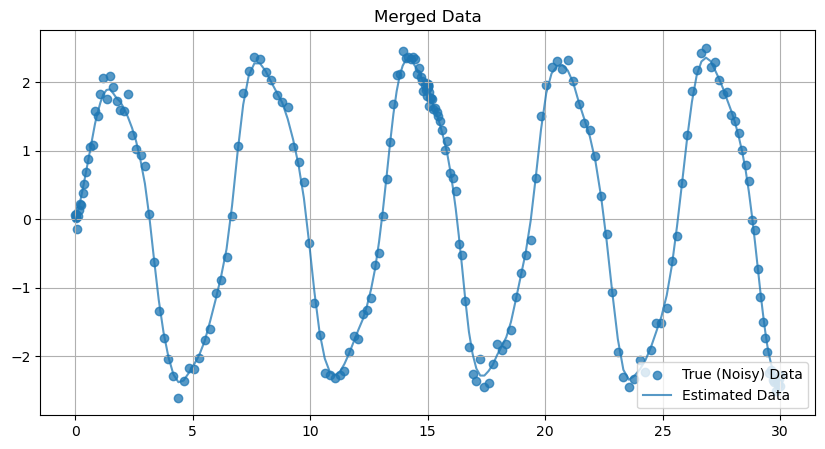

In [6]:
plt.figure(figsize=(10, 5))
plt.scatter(ts, ys, label='True (Noisy) Data', alpha = 0.75)
# plt.plot(ts, Xs, label='True (Noisy) Data - aux', alpha = 0.75)
plt.plot(ts, y_est, label='Estimated Data', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

In [7]:
import nn_pyomo_admm
importlib.reload(nn_pyomo_admm)
NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

tol = 1e-7
params = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 1, "max_iter": 500}

layer_sizes = [2, 20, 1]

ode_model = NeuralODEPyomoADMM(y_observed = ys, 
                        t = ts, # t
                        first_derivative_matrix = Ds, # derivative matrix
                        extra_input = Xs, # extra inputs
                        y_init = y_est,
                        layer_sizes = layer_sizes, act_func = "tanh", 
                        penalty_lambda_reg = 0.01, 
                        rho = 10.0,
                        time_invariant = True,
                        w_init_method = 'xavier', 
                        params = params
                        )

result = ode_model.admm_solve(iterations=10, tol_primal=1e-2)

----------------------------------------------------------------------------------------------------
ADMM Iteration 1/10; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
halt_on_ampl_error=yes
print_level=1
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
halt_on_ampl_error=yes
print_level=1
max_iter=500


******************************************************************************
This program contains Ipopt, a lib

In [8]:
result